In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping , ReduceLROnPlateau , ModelCheckpoint
from keras.models import load_model
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

Using TensorFlow backend.


In [2]:
# network structure. 
# not to include the input layer
net_layers = (11,9,8,4)

epochs=200
batch_size=300

learning_rate = 1e-3
decay = learning_rate / epochs

patience=80

test_split = 0.1
validation_split = 0.2

# trials
# 11 R2-> -0.12
# 11,16,8,4 R2-> 0.37
# 11,11,6 R2-> -0.2
# 11,8,6 R2->   0.316
# 11,11,8,4 R2->  0.37
# 11, 6 R2-> 0.37

In [3]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'
models_dir = home_dir + "/models/"

data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
#data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


In [4]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [5]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.03,0.01,0.01,0.01,0.01,0.01,0.01,0.03,0.07,1.00,1.00,1.00,1.00,1.00,1.00,2.50,0.15,0.24
1,0.06,0.02,0.02,0.02,0.02,0.01,0.01,0.18,0.18,1.00,1.00,1.00,1.00,1.00,1.00,1.89,0.15,0.24
2,0.07,0.03,0.02,0.03,0.02,0.01,0.01,0.44,0.20,1.00,1.00,1.00,1.00,1.00,1.00,1.35,0.15,0.24
3,0.07,0.03,0.02,0.02,0.02,0.01,0.01,0.23,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.26,0.13,0.24
4,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.24,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.28,0.36,0.24


In [6]:
data.shape

(6766, 18)

In [7]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))

there are 17 features


# Feature Selection

In [8]:
feature_list = inputs.columns.values
if False:
    sfm = SelectFromModel(
                RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15),
                threshold='0.8*mean')

    selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = inputs.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    
    print("columns selected are {}".format(features))

    inputs = inputs[feature_list]
    inputs.head(2)

In [9]:
n_inputs = len(feature_list)
n_inputs

17

In [10]:
#n_inputs = selectedFeatures[1].shape[0]
#n_inputs

In [11]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=True, random_state=365)

print("y_train {} , y_test {}".format(y_train.shape, y_test.shape))

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max


y_train (6089,) , y_test (677,)


In [12]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)  # fit on training data only
x_test = scaler.transform(x_test)

## Function to build a model

In [13]:
def build_keras_model(nodes = net_layers):   # this does not work with KerasRegressor. interesting
    # create model
    model = Sequential()  
    
    if isinstance(nodes, int) or not nodes:
        model.add(Dense(1, input_dim=n_inputs, kernel_initializer='normal'))
    
    else:
        model.add(Dense(nodes[1], input_dim=n_inputs, kernel_initializer='normal', activation='relu'))
    
        layer = 0
        while layer < len(nodes):
            model.add(Dense(nodes[layer], kernel_initializer='normal', activation='relu'))
            layer = layer + 1
        
        #model.add(Dense(1, kernel_initializer='normal', activation='linear')) 
        model.add(Dense(1, kernel_initializer='normal', activation='linear'))  
    
    adam = Adam(lr=learning_rate, decay=decay)
    
    # or loss= 'mean_absolute_percentage_error'
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mse'])
    
    return model


In [14]:
model = build_keras_model()

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

# save the best model only
mc = ModelCheckpoint(models_dir + 'best_mlp_model.h5'
                     , monitor='val_loss'
                     , mode='min' 
                     , verbose=1
                     #, save_weights_only=True
                     , save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [es, mc, reduce_lr]

history = model.fit(x_train, y_train
                    , epochs=epochs
                    , batch_size=batch_size
                    , verbose=1
                    , validation_split=validation_split
                    , shuffle=False
                    , callbacks=callbacks)

print ("Done..!")









Train on 4871 samples, validate on 1218 samples
Epoch 1/200





4871/4871 [==============================] - 2s 344us/step - loss: 0.2175 - mean_squared_error: 0.2175 - val_loss: 0.2074 - val_mean_squared_error: 0.2074

Epoch 00001: val_loss improved from inf to 0.20739, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 2/200
4871/4871 [==============================] - 0s 11us/step - loss: 0.2058 - mean_squared_error: 0.2058 - val_loss: 0.1950 - val_mean_squared_error: 0.1950

Epoch 00002: val_loss improved from 0.20739 to 0.19504, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 3/200
4871/4871 [==============================] - 0s 12us/step - loss: 0.1929 - mean_squared_error: 0.1929 - val_loss: 0.1808 - val_mean_squared_error: 0.1808

Epoch 00003: val_loss improved from 0.19504 to 0.18085, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/mo


Epoch 00018: val_loss improved from 0.06841 to 0.06791, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 19/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0674 - mean_squared_error: 0.0674 - val_loss: 0.0675 - val_mean_squared_error: 0.0675

Epoch 00019: val_loss improved from 0.06791 to 0.06749, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 20/200
4871/4871 [==============================] - 0s 12us/step - loss: 0.0669 - mean_squared_error: 0.0669 - val_loss: 0.0672 - val_mean_squared_error: 0.0672

Epoch 00020: val_loss improved from 0.06749 to 0.06717, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 21/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.0669 - val_mean_squared_error: 0.0669

Epoch 00021: val_loss improved

Epoch 44/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0613 - mean_squared_error: 0.0613 - val_loss: 0.0621 - val_mean_squared_error: 0.0621

Epoch 00044: val_loss improved from 0.06238 to 0.06206, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 45/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0618 - val_mean_squared_error: 0.0618

Epoch 00045: val_loss improved from 0.06206 to 0.06177, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 46/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0607 - mean_squared_error: 0.0607 - val_loss: 0.0615 - val_mean_squared_error: 0.0615

Epoch 00046: val_loss improved from 0.06177 to 0.06151, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 47/200
4871/4871 [=======


Epoch 00069: val_loss improved from 0.04437 to 0.04390, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 70/200
4871/4871 [==============================] - 0s 13us/step - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0435 - val_mean_squared_error: 0.0435

Epoch 00070: val_loss improved from 0.04390 to 0.04352, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 71/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0432 - val_mean_squared_error: 0.0432

Epoch 00071: val_loss improved from 0.04352 to 0.04317, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 72/200
4871/4871 [==============================] - 0s 12us/step - loss: 0.0395 - mean_squared_error: 0.0395 - val_loss: 0.0427 - val_mean_squared_error: 0.0427

Epoch 00072: val_loss improved


Epoch 00094: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 95/200
4871/4871 [==============================] - 0s 11us/step - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0381 - val_mean_squared_error: 0.0381

Epoch 00095: val_loss improved from 0.03837 to 0.03809, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 96/200
4871/4871 [==============================] - 0s 14us/step - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0379 - val_mean_squared_error: 0.0379

Epoch 00096: val_loss improved from 0.03809 to 0.03787, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 97/200
4871/4871 [==============================] - 0s 11us/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0378 - val_mean_squared_error: 0.0378

Epoch 00097: val_loss improved from 0.03787 to 0.03782, saving model to /Users/hmohamed/github/data-rese

Epoch 120/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0318 - mean_squared_error: 0.0318 - val_loss: 0.0376 - val_mean_squared_error: 0.0376

Epoch 00120: val_loss improved from 0.03758 to 0.03757, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 121/200
4871/4871 [==============================] - 0s 9us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0376 - val_mean_squared_error: 0.0376

Epoch 00121: val_loss improved from 0.03757 to 0.03756, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 122/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0375 - val_mean_squared_error: 0.0375

Epoch 00122: val_loss improved from 0.03756 to 0.03755, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 123/200
4871/4871 [====

4871/4871 [==============================] - 0s 10us/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0373 - val_mean_squared_error: 0.0373

Epoch 00145: val_loss improved from 0.03733 to 0.03732, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 146/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0373 - val_mean_squared_error: 0.0373

Epoch 00146: val_loss improved from 0.03732 to 0.03731, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 147/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0373 - val_mean_squared_error: 0.0373

Epoch 00147: val_loss improved from 0.03731 to 0.03730, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 148/200
4871/4871 [=================


Epoch 00170: val_loss improved from 0.03709 to 0.03708, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 171/200
4871/4871 [==============================] - 0s 9us/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0371 - val_mean_squared_error: 0.0371

Epoch 00171: val_loss improved from 0.03708 to 0.03708, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 172/200
4871/4871 [==============================] - 0s 11us/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0371 - val_mean_squared_error: 0.0371

Epoch 00172: val_loss improved from 0.03708 to 0.03707, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 173/200
4871/4871 [==============================] - 0s 9us/step - loss: 0.0309 - mean_squared_error: 0.0309 - val_loss: 0.0371 - val_mean_squared_error: 0.0371

Epoch 00173: val_loss improve

Epoch 196/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0369 - val_mean_squared_error: 0.0369

Epoch 00196: val_loss improved from 0.03688 to 0.03687, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 197/200
4871/4871 [==============================] - 0s 10us/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0369 - val_mean_squared_error: 0.0369

Epoch 00197: val_loss improved from 0.03687 to 0.03686, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 198/200
4871/4871 [==============================] - 0s 9us/step - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0369 - val_mean_squared_error: 0.0369

Epoch 00198: val_loss improved from 0.03686 to 0.03686, saving model to /Users/hmohamed/github/data-research-spring2020/sock-shop/models/best_mlp_model.h5
Epoch 199/200
4871/4871 [====

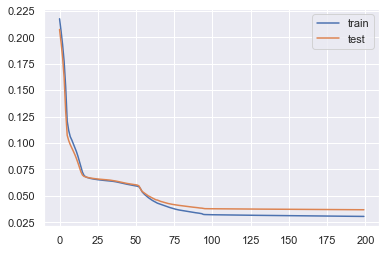

In [15]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [16]:
val_loss = history.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)

print("Model Validation MSE mean: %.2f  std: (%.2f)" % \
      (val_loss_df.mean(), val_loss_df.std()))


Model Validation MSE mean: 0.05  std: (0.03)


In [17]:
# load the saved model
saved_model = load_model(models_dir + 'best_mlp_model.h5')

# evaluate the model
train_loss, train_mse = saved_model.evaluate(x_train, y_train, verbose=0)
test_loss, test_mse = saved_model.evaluate(x_test, y_test, verbose=0)
print('Train MSE: %.3f, Test MSE: %.3f' % (train_mse, test_mse))

Train MSE: 0.032, Test MSE: 0.036


In [18]:
#regressor.fit(x_train, y_train)
y_hat = saved_model.predict(x_train)
y_hat

array([[0.03486371],
       [0.4839539 ],
       [0.4839539 ],
       ...,
       [0.48395383],
       [0.48395383],
       [0.87421256]], dtype=float32)

In [19]:
r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

R2 (training) = 0.755264604924634


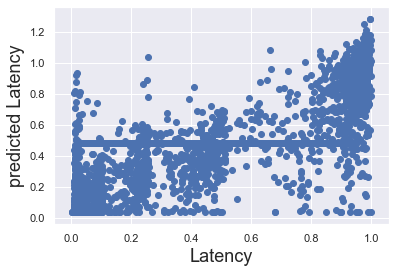

In [20]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

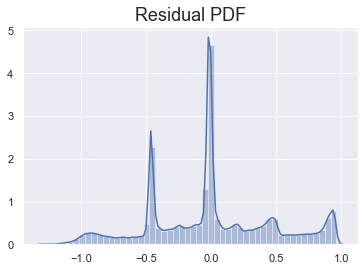

In [21]:
y_train = y_train.values
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [22]:
# evaluation mean_absolute_percentage_error
train_error =  y_train - y_hat
train_error

mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

print("Train Residual mean: %.2f std: %.2f  min; %.2f max: %.2f" \
      % (mean_error, std_error, min_error, max_error))

Train Residual mean: 0.00 std: 0.48  min; -1.28 max: 0.97


### Testing

In [23]:
y_hat_test = saved_model.predict(x_test)
y_hat_test[:20]

array([[0.3155693 ],
       [0.2384268 ],
       [0.03486371],
       [0.03486371],
       [0.220072  ],
       [0.25797233],
       [0.03486371],
       [0.45762423],
       [0.03563204],
       [0.03486371],
       [0.4839539 ],
       [0.951936  ],
       [0.4839539 ],
       [1.004723  ],
       [0.03486371],
       [0.07475099],
       [0.08673096],
       [0.03486371],
       [0.4053779 ],
       [0.03486371]], dtype=float32)

<function matplotlib.pyplot.show(*args, **kw)>

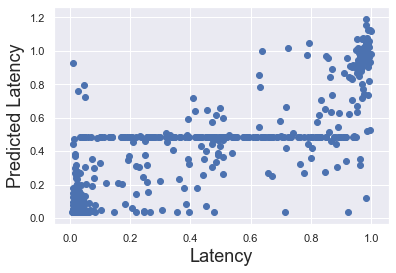

In [24]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

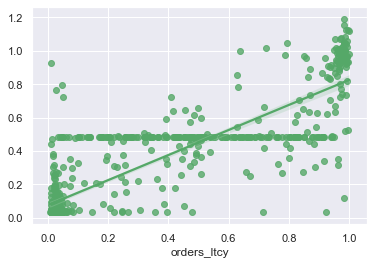

In [25]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [26]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.37,2.62
1,1.27,1.08
2,1.04,1.49
3,1.04,1.02
4,1.25,1.35


In [27]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.37,2.62,-1.25,47.71
1,1.27,1.08,0.19,17.13
2,1.04,1.49,-0.45,30.35
3,1.04,1.02,0.01,1.12
4,1.25,1.35,-0.10,7.46
...,...,...,...,...
672,1.04,1.03,0.01,1.02
673,1.62,1.21,0.41,34.12
674,1.15,1.02,0.13,12.33
675,1.04,1.03,0.01,1.02


In [28]:
perf.describe()

,prediction,target,residual,difference%
count,677.00,677.00,677.00,677.00
mean,1.45,1.48,-0.03,11.49
std,0.53,0.60,0.32,15.62
min,1.04,1.01,-1.55,0.02
25%,1.04,1.03,-0.06,1.02
50%,1.22,1.06,0.01,3.93
75%,1.62,1.88,0.07,17.72
max,3.29,2.72,1.51,149.79


In [29]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
554,1.04,1.04,-0.00,0.02
259,1.62,1.62,0.00,0.08
327,1.04,1.03,0.00,0.09
332,1.04,1.03,0.00,0.09
52,1.04,1.04,-0.00,0.12
527,1.04,1.04,-0.00,0.12
133,2.66,2.66,0.00,0.16
132,1.05,1.05,0.00,0.17
349,2.64,2.65,-0.00,0.18
257,1.04,1.03,0.00,0.19


# Prediction Accuracy

In [30]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

R2 (testing) = 0.7298933057758921


In [31]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.18857813993482034
